#TP2: Regresion Polinomica - Baltazar Etchepareborda

El trabajo practico esta hecho en dos partes, primero el manejo de datos basico que es comun al mismo, exploracion de datos, ingesta, limpieza de datos, exploracion basica (Puntos a.1 a.2 a.3). Luego b.1 y b.2 se hacen las transformaciones para codificacion de variables numericas y categoricas a parte.
Como recien se introduce Column Transformer y Pipeline en b.3, ahi cambie el metodo y volvi a hacer todo ya que es mas practico y limpio

##Importacion de librerias

In [ ]:
# Importo librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

##Exploracion de datos

Con el curl traigo los datos directamente del GIT, head me da las primeras 5 filas para poder ver en que se basan los datos
a1. Cargar el archivo car_data.csv.

In [ ]:
!curl -L -o car_data.csv https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/car_data.csv
data = pd.read_csv('car_data.csv')
type(data) #pandas.core.frame.DataFrame
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18812  100 18812    0     0  77871      0 --:--:-- --:--:-- --:--:-- 78058


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Set
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,Train
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,Train
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,Train
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,Train
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,Test


1. Cargar el archivo car_data.csv. Descartar las columnas correspondientes al nombre del auto y su
dueno.

In [ ]:
#Reviso las primeras cinco filas para ver el dataset
data.head()
data = data.drop(['Owner','Car_Name'],axis=1)#Limpio las columnas

2. Definir los conjuntos de entrenamiento, testeo y validacion en base a la informacion en la columna
Set. c: Una vez hecho este paso la informacion de esa feature no sera de utilidad para la regresion

In [ ]:
data['Set'].value_counts() #Tiene tres tipos, Validation, Train y Test
training_set = data[(data['Set'] == 'Train')].drop('Set',axis=1)
validation_set = data[(data['Set'] == 'Validation')].drop('Set',axis=1)
test_set = data[(data['Set'] == 'Test') | (data['Set'] == 'Validation')].drop('Set',axis=1)
data = data.drop('Set',axis=1)

3. Indicar la proporcion de las variables categoricas representando probabilidades. c: Si no sabe que
tipo de variable aleatoria es la categorica, debera buscar dicha informacion.

Las variables categoricas van a ser aquellas que no tienen un orden, no suelen ser numericas. Para este caso, pasandole normalizar a value counts tenemos la proporcion directamente para cada una de las tres variables categoricas

Seller type: Dealer 0.647 y Individual 0.35219

Tranmission: Manual	0.86711 Automatic	0.13289

Fuel Type: Petrol: 0.794020 Diesel 0.199336 CNG 0.006645


In [ ]:
tranmission_proportion = data['Transmission'].value_counts(normalize=True)
seller_type_proportion = data['Seller_Type'].value_counts(normalize=True)
fuel_type_proportion = data['Fuel_Type'].value_counts(normalize=True)
#year_proportion = data['Year'].value_counts(normalize=True)
print(tranmission_proportion ,seller_type_proportion,fuel_type_proportion)

Transmission
Manual       0.86711
Automatic    0.13289
Name: proportion, dtype: float64 Seller_Type
Dealer        0.647841
Individual    0.352159
Name: proportion, dtype: float64 Fuel_Type
Petrol    0.794020
Diesel    0.199336
CNG       0.006645
Name: proportion, dtype: float64


##Pre-procesamiento:
1. Utilizar el comando OneHotEncoder (sklearn) para codificar las variables categoricas de mas de dos
clases como one-hot y las categoricas de dos clases como binarias.
Para 3 valores cualquiera deberia devolver 100, 010, 001.
4 valores 1000 0100 0010 0001 y desconocidos todo en 1 y asi.

ACLARACION: Esta forma de hacerlo es poco eficiente y se volvio a hacer con pipeline y column transformer, el enfoque fue basicamente ver que columnas corresponden a las categoricas, transformar por una parte la de onehot con 3 variables, por otra parte las binarias y hacer un join con el dataframe en bulk y droppear las categoricas originales.

In [ ]:
######HAGO LA PARTE DE ONEHOT #######
preprocesador_onehot = OneHotEncoder(sparse_output = False)
#El OneHotEncoder hay que usarlo con para el Fuel Type porque es la que tiene 3 tipos de variables.
data_onehot = data[['Fuel_Type']]
preprocesador_onehot = preprocesador_onehot.fit(data_onehot)
codificados = preprocesador_onehot.transform(data_onehot)
columnas = preprocesador_onehot.get_feature_names_out(['Fuel_Type'])
cod = pd.DataFrame(codificados, columns=columnas)
data = pd.concat([data,cod],axis=1)

###Parte binaria####
preprocesador_binary = OneHotEncoder(drop='if_binary',sparse_output=False)
data_binary = data[['Seller_Type','Transmission']]
preprocesador = preprocesador_binary.fit(data_binary)
codificados_binary = preprocesador_binary.transform(data_binary)
df_binary = pd.DataFrame(codificados_binary,columns = ['Seller_Individual','Transmission_Manual'])
data = pd.concat([data,df_binary],axis=1)
data = data.drop(['Transmission','Seller_Type','Fuel_Type'],axis=1)

#print(codificados_binary.categories_)
#df_binary = pd.DataFrame(codificados_binary,columns = [])
#type(codificados_binary)
#print(codificados)
#print(preprocesador.categories_)
#df_binary.head()

Vuelvo a hacerlo todo con pipeline y ColumnTransformer que es mas sencillo (me di cuenta cuando llegue al 3.1)


### Polinomial features
Utilice el comando PolynomialFeatures (sklearn) para crear un mapa polinomico de orden 3 sobre
las variables numericas (exceptuando el precio de venta que seria la variable a predecir).

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Defino columnas originales
cols = ['Present_Price','Kms_Driven','Year']

# Defino PolynomialFeatures sin bias
polfeatures = PolynomialFeatures(degree=3, include_bias=False)

# Fit-transform sobre las columnas originales
X_poly = polfeatures.fit_transform(data[cols])

# Convierto a DataFrame con los nombres correctos
X_poly_df = pd.DataFrame(
    X_poly,
    columns=polfeatures.get_feature_names_out(cols),
    index=data.index
)

# Escalar
polfeat = data.drop('Selling_Price', axis=1)
polfeat_std = StandardScaler().fit_transform(polfeat)

# Borro las columnas originales
data = data.drop(cols, axis=1)

# Concateno las nuevas columnas polinómicas
data = pd.concat([data, X_poly_df], axis=1)




In [ ]:
data.head()

,Selling_Price,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Individual,Transmission_Manual,Present_Price,Kms_Driven,Year,Present_Price^2,...,Present_Price^3,Present_Price^2 Kms_Driven,Present_Price^2 Year,Present_Price Kms_Driven^2,Present_Price Kms_Driven Year,Present_Price Year^2,Kms_Driven^3,Kms_Driven^2 Year,Kms_Driven Year^2,Year^3
0,3.35,0.0,0.0,1.0,0.0,1.0,5.59,27000.0,2014.0,31.2481,...,174.676879,843698.700,62933.6734,4.075110e+09,303973020.0,22674135.64,1.968300e+13,1.468206e+12,1.095173e+11,8.169179e+09
1,4.75,0.0,1.0,0.0,0.0,1.0,9.54,43000.0,2013.0,91.0116,...,868.250664,3913498.800,183206.3508,1.763946e+10,825772860.0,38657692.26,7.950700e+13,3.722037e+12,1.742433e+11,8.157016e+09
2,7.25,0.0,0.0,1.0,0.0,1.0,9.85,6900.0,2017.0,97.0225,...,955.671625,669455.250,195694.3825,4.689585e+08,137085405.0,40072646.65,3.285090e+11,9.602937e+10,2.807119e+10,8.205739e+09
3,2.85,0.0,0.0,1.0,0.0,1.0,4.15,5200.0,2011.0,17.2225,...,71.473375,89557.000,34634.4475,1.122160e+08,43397380.0,16783102.15,1.406080e+11,5.437744e+10,2.102943e+10,8.132727e+09
4,4.60,0.0,1.0,0.0,0.0,1.0,6.87,42450.0,2014.0,47.1969,...,324.242703,2003508.405,95054.5566,1.237976e+10,587345841.0,27866066.52,7.649501e+13,3.629233e+12,1.721855e+11,8.169179e+09


Ahora si, hechos los puntos 3.1 en adelante todo con Pipeline y Column Transformer

(c) Regresion lineal:
1. Utilizar Pipeline (sklearn) para combinar las operaciones anteriores con una regresion lineal. c:
Se recomienda utilizar LinearRegression (sklearn).
2. ¿Cuantos parametros tiene el modelo? Explicar por que.
3. Utilizar display para hacer un diagrama del sistema definido.
4. Entrenar el sistema descripto anteriormente.
5. Reportar el error cuadrarico medio de entrenamiento y validacion.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from IPython.display import display
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
!curl -L -o car_data.csv https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/car_data.csv
data = pd.read_csv('car_data.csv')
data = data.drop(['Owner','Car_Name'],axis=1)#Limpio las columnas
training_set = data[(data['Set'] == 'Train')].drop('Set',axis=1)
test_set = data[(data['Set'] == 'Test')].drop('Set',axis=1)
validation_set = data[(data['Set']== 'Validation')].drop('Set',axis=1)
data = data.drop('Set',axis=1)
#type(data) #pandas.core.frame.DataFrame
#data.head()
#Reviso las primeras cinco filas para ver el dataset
#data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18812  100 18812    0     0  77123      0 --:--:-- --:--:-- --:--:-- 77415



 Primero elevo todas las componentes al cubo de las features numericas y las guardo en columnas separadas $x, x^2, x^3$ y asi con cada una de las tres, ademas, se hace el producto de unas variables numericas con las otras.

 Entonces, como son 3 variables variables numericas, se arman todas las combinaciones hasta grado tres.

 Para grado 1: $x1 x2 x3$
 Para grado 2: $x1x2, x1x3 ,x2x3, x1^2, x2^2, x3^2$
 Para grado 3: $x1^2x2 ,x1^2x3 ,x2^2x1, x2^2x3, x3^2x1, x3^2x2, x3^3, x2^3, x1^3,x1x2x3$

 En total, 19. Es una binomial 6,3.


 Despues con el column transformer armo el procesador que usa onehot con una columna para las categoricas binarias y 3 columnas para la categorica de tres variables, eso se logra con el drop if binary (porque si no crearia 2 2 y 3).

 Se suman 5 columnas mas. (3+1+1).

 Entonces el total de parametros antes de la regresion es 24, con la ordenada al origen del lineal regressor quedan en 25.

 Se declaran las transformaciones dentro del column transformer para anidarlo despues en un Pipeline que primero preprocese con estos pasos y despues haga regresion lineal.


In [ ]:

cat_cols = ['Fuel_Type','Seller_Type','Transmission']
num_cols = ['Present_Price','Kms_Driven','Year']
# Primero elevo todas las componentes al cubo de las features numericas y las guardo en columnas separadas x x^2 x^3 y asi con cada una de las tres
# Despues a esos mismos datos los normalizo porque son muy diferentes entre si.
num_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler())
])
# ColumnTransformer combinando categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('categoricas', OneHotEncoder( drop='if_binary'), cat_cols),
        ('numericas', num_pipeline, num_cols)
    ]
)
#Primero se preprocesan los datos con el objeto preprocessor y despues se hace la regresion lineal
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Entrenar el modelo
X = training_set.drop('Selling_Price', axis=1)  # Esta es y para el training set
y = training_set['Selling_Price']
model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoricas',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission']),
                                                 ('numericas',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Kms_Driven', 'Year'])])),
                ('regressor', LinearRegression())])

Aca hago lo mismo para los tres casos para mostrar el ECM para cada uno
El pipeline se ve en el diagrama que para las categoricas aplica onehot encoder, para las numericas las eleva con polynomial features, las escala y despues a la combinacion le hace regresion lineal, que es lo que vimos que queriamos conseguir arriba.

In [ ]:
set_config(display='diagram') #Para mostrar el diagrama en bloques.
display(model_pipeline)
# Entrenamiento
y_train_pred = model_pipeline.predict(X)
mse_train = mean_squared_error(y, y_train_pred)
print("MSE entrenamiento:", mse_train)

# Validación / Test
X_val = validation_set.drop('Selling_Price', axis=1)
y_val = validation_set['Selling_Price']
y_val_pred = model_pipeline.predict(X_val)
mse_val = np.mean((y_val - y_val_pred)**2)
print("MSE val:", mse_val)

X_test = test_set.drop('Selling_Price', axis=1)
y_test = test_set['Selling_Price']
y_test_pred = model_pipeline.predict(X_test)
mse_test = np.mean((y_test - y_test_pred)**2)
print("MSE test:", mse_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoricas',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission']),
                                                 ('numericas',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Kms_Driven', 'Year'])])),
                ('regressor', LinearRegression())])

MSE entrenamiento: 0.4726923559559848
MSE val: 0.5419991552287715
MSE test: 0.5854715758257468


(d) Regularizacion
1. Combinar Ridge (sklearn) con Pipeline para implementar una regresion polinomica regularizada.
2. Entrenar una regresion regularizada para diferentes valores de 10−6 < λ < 10−2.
3. Graficar el error cuadratico medio de entrenamiento y validacion en funcion de λ.
4. Reportar el λ que minimiza el error cuadrarico medio de validacion.
5. Reportar el error cuadrarico medio de testeo para el λ obtenido anteriormente.

Aca se hizo lo mismo pero con el regresor declarado como Ridge, si se le pasa parametro cero es lo mismo que la regresion lineal segun la documentacion, pero si se le pasa un cierto alpha, se suavizan mas los datos para prevenir el overfitting. Cuanto mas alto alpha mas regularizados estan los datos, si es muy bajo no habria cambio, si es muy alto estarian muy suavizados y no generalizarian a nuevas muestras.

In [ ]:
from sklearn.linear_model import Ridge
# Columnas categóricas y numéricas
# Pipeline completo con regresión lineal
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
# Entrenar el modelo

N_lambda = 300 #Despues si quiero iterar mas lo puedo levantar a este numero pero parece que es suficiente
lambdas = np.linspace(1e-6,1e-2,N_lambda)

mse_train_arr = []
mse_test_arr = []
mse_val_arr = []

X = training_set.drop('Selling_Price', axis=1)  # variables independientes
X_test = test_set.drop('Selling_Price', axis=1)
X_val = validation_set.drop('Selling_Price', axis=1)

y = training_set['Selling_Price']               # variable objetivo
y_val = validation_set['Selling_Price']
y_test = test_set['Selling_Price']

for lamb in lambdas:
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=lamb))
])
  model_pipeline.fit(X, y)
  y_train_pred = model_pipeline.predict(X)
  mse_train = mean_squared_error(y, y_train_pred)
  mse_train_arr.append(mse_train)

  y_test_pred = model_pipeline.predict(X_test)
  mse_test = np.mean((y_test - y_test_pred)**2)
  mse_test_arr.append(mse_test)

  y_val_pred = model_pipeline.predict(X_val)
  mse_val = np.mean((y_val - y_val_pred)**2)
  mse_val_arr.append(mse_val)

  #print(f"MSE entrenamiento:{mse_train} | MSE test: {mse_test} | MSE val: {mse_val} con lambda: {lamb}")

Esta seccion es solamente para ver los cambios del ECM para la variacion de lambda, el lambda optimo como hiperparametro se consigue viendo el minimo de la curva del error de validacion, despues se confirma que tiene un bajo valor en el set de testeo.

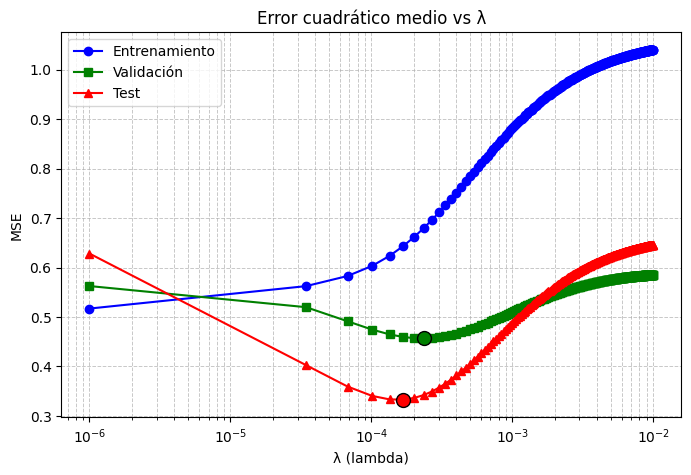

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(lambdas, mse_train_arr, marker='o', color='blue', label='Entrenamiento')
plt.plot(lambdas, mse_val_arr, marker='s', color='green', label='Validación')
plt.plot(lambdas, mse_test_arr, marker='^', color='red', label='Test')

idx_test = np.argmin(mse_test_arr)
idx_val = np.argmin(mse_val_arr)

plt.scatter(lambdas[idx_val], mse_val_arr[idx_val], color='green', s=100, edgecolors='black', zorder=5)
plt.scatter(lambdas[idx_test], mse_test_arr[idx_test], color='red', s=100, edgecolors='black', zorder=5)

plt.xscale('log')  # porque los lambda están en escala logarítmica
plt.xlabel("λ (lambda)")
plt.ylabel("MSE")
plt.title("Error cuadrático medio vs λ")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.7, alpha=0.7)

plt.show()


In [ ]:
lambda_val_min_ecm = lambdas[np.argmin(mse_val_arr)]
print(f"El lambda que minimiza el ECM para el test de validacion  (optimo) es: {lambda_val_min_ecm}")
print(f"El ECM de testeo para el lambda optimo es: {mse_test_arr[idx_val]}")
print(f"El ECM de val para el lambda optimo es: {mse_val_arr[idx_val]}")

El lambda que minimiza el ECM para el test de validacion  (optimo) es: 0.00023509030100334448
El ECM de testeo para el lambda optimo es: 0.3420829937822786
El ECM de val para el lambda optimo es: 0.4567160642538887
